**Script Description:**
This script loads, cleans, and pre-processes the datset to prepare it for modeling. It defines and fits a 5-parameter non-linear model to predict Nighttime Ecosystem Exchange (NEE) of CO2 based on Gross Primary Production (GPP), air temperature (ATMP), soil moisture content (Planet_SMC), and soil temperature (STMP). The script uses multiple initial guesses and parallel processing (`joblib`) for robust parameter estimation via non-linear least squares (`scipy.optimize.curve_fit`). Finally, it evaluates the model's performance using standard regression metrics (R², MSE, RMSE, MAE, Bias, ubRMSE) and visualizes the observed vs. predicted NEE, residuals, and the model's predicted response against Planet_SMC.

**File Name:** 03_01_NEE_SMC_non_lin_model.ipynb

**Date:** 2025

**Created by:** Rob Alamgir

##### Import the relevant packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy.stats import norm
from itertools import product
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import scipy.stats as stats
import itertools
from joblib import Parallel, delayed
import warnings

### Step 1: Load and preprocess data

In [2]:
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data_Final/Pre_Processed_Data_All_Locations_V6.csv"
complete_dataset = pd.read_csv(data_path, low_memory=False)
complete_dataset['Date'] = pd.to_datetime(complete_dataset['Date'])

# Select relevant columns
columns_of_interest = ['Date', 'Site_ID', 'Planet_SMC', 'NEE_CO2_kg_day_ha_DAv_NT',
                       'GPP_NT_kg_day_ha_DAv_NT', 'STMP_1_015', 'ATMP_f', 'Porosity_BIS4D_SOM']
selected_df = complete_dataset[columns_of_interest]

# Filter for plausible physiological ranges
filtered_df = selected_df[
    (selected_df['NEE_CO2_kg_day_ha_DAv_NT'] >= 0) &
    (selected_df['NEE_CO2_kg_day_ha_DAv_NT'] <= 800) &
    (selected_df['GPP_NT_kg_day_ha_DAv_NT'] >= 0) &
    (selected_df['GPP_NT_kg_day_ha_DAv_NT'] <= 500)
].copy()

# Drop NaNs in model-related columns
model_columns = ['Date', 'Site_ID', 'NEE_CO2_kg_day_ha_DAv_NT', 'GPP_NT_kg_day_ha_DAv_NT',
                 'ATMP_f', 'Planet_SMC', 'STMP_1_015', 'Porosity_BIS4D_SOM']
cleaned_df = filtered_df.dropna(subset=model_columns).copy()

# Check for remaining NaNs and Infs
print("Checking for NaNs:")
print(cleaned_df[model_columns[2:]].isnull().sum())

print("\nChecking for Infs:")
print(cleaned_df[model_columns[2:]].apply(lambda x: np.isinf(x).sum()))

Checking for NaNs:
NEE_CO2_kg_day_ha_DAv_NT    0
GPP_NT_kg_day_ha_DAv_NT     0
ATMP_f                      0
Planet_SMC                  0
STMP_1_015                  0
Porosity_BIS4D_SOM          0
dtype: int64

Checking for Infs:
NEE_CO2_kg_day_ha_DAv_NT    0
GPP_NT_kg_day_ha_DAv_NT     0
ATMP_f                      0
Planet_SMC                  0
STMP_1_015                  0
Porosity_BIS4D_SOM          0
dtype: int64


#### Plot scatter plots of the main parameters

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), 
                         gridspec_kw={'wspace': 0.3, 'hspace': 0.165})

# Plot 1
sc1 = sns.scatterplot(data=filtered_df.dropna(subset=['STMP_1_015']),
                      x='Planet_SMC', y='NEE_CO2_kg_day_ha_DAv_NT',
                      hue='STMP_1_015', palette='plasma', s=40, ax=axes[0, 0], legend=False)
axes[0, 0].axhline(0, color='black', linewidth=1, linestyle='--')
norm1 = Normalize(vmin=filtered_df['STMP_1_015'].min(), vmax=filtered_df['STMP_1_015'].max())
cbar1 = fig.colorbar(cm.ScalarMappable(norm=norm1, cmap='plasma'), ax=axes[0, 0], pad=0.01)
cbar1.set_label('Soil Temperature [°C]', fontweight='bold')
axes[0, 0].set_xlabel("Planet SMC [m$^{3}$ m$^{-3}$]", fontweight='bold')
axes[0, 0].set_ylabel("NEE CO₂ [kg day$^{-1}$ ha$^{-1}$]", fontweight='bold')
axes[0, 0].text(0.02, 0.95, '(a)', transform=axes[0, 0].transAxes, fontsize=14, fontweight='bold', va='top')
# Plot 2
sc2 = sns.scatterplot(data=filtered_df.dropna(subset=['Planet_SMC']),
                      x='STMP_1_015', y='NEE_CO2_kg_day_ha_DAv_NT',
                      hue='Planet_SMC', palette='Blues', s=40, ax=axes[0, 1], legend=False)
axes[0, 1].axhline(0, color='black', linewidth=1, linestyle='--')
norm2 = Normalize(vmin=filtered_df['Planet_SMC'].min(), vmax=filtered_df['Planet_SMC'].max())
cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm2, cmap='Blues'), ax=axes[0, 1], pad=0.01)
cbar2.set_label('Planet SMC [m$^{3}$ m$^{-3}$]', fontweight='bold')
axes[0, 1].set_xlabel("Soil Temperature [°C]", fontweight='bold')
axes[0, 1].set_ylabel("NEE CO₂ [kg day$^{-1}$ ha$^{-1}$]", fontweight='bold')
axes[0, 1].text(0.02, 0.95, '(b)', transform=axes[0, 1].transAxes, fontsize=14, fontweight='bold', va='top')
# Plot 3
sc3 = sns.scatterplot(data=filtered_df.dropna(subset=['GPP_NT_kg_day_ha_DAv_NT']),
                      x='Planet_SMC', y='NEE_CO2_kg_day_ha_DAv_NT',
                      hue='STMP_1_015', palette='crest', s=40, ax=axes[1, 0], legend=False)
axes[1, 0].axhline(0, color='black', linewidth=1, linestyle='--')
norm3 = Normalize(vmin=filtered_df['GPP_NT_kg_day_ha_DAv_NT'].min(), vmax=filtered_df['GPP_NT_kg_day_ha_DAv_NT'].max())
cbar3 = fig.colorbar(cm.ScalarMappable(norm=norm3, cmap='crest'), ax=axes[1, 0], pad=0.01)
cbar3.set_label('GPP CO₂ [kg day$^{-1}$ ha$^{-1}$]', fontweight='bold')
axes[1, 0].set_xlabel("Planet SMC [m$^{3}$ m$^{-3}$]", fontweight='bold')
axes[1, 0].set_ylabel("NEE CO₂ [kg day$^{-1}$ ha$^{-1}$]", fontweight='bold')
axes[1, 0].text(0.02, 0.95, '(c)', transform=axes[1, 0].transAxes, fontsize=14, fontweight='bold', va='top')
# Plot 4
sc4 = sns.scatterplot(data=filtered_df.dropna(subset=['GPP_NT_kg_day_ha_DAv_NT']),
                      x='ATMP_f', y='NEE_CO2_kg_day_ha_DAv_NT',
                      hue='GPP_NT_kg_day_ha_DAv_NT', palette='crest', s=40, ax=axes[1, 1], legend=False)
axes[1, 1].axhline(0, color='black', linewidth=1, linestyle='--')
norm4 = Normalize(vmin=filtered_df['GPP_NT_kg_day_ha_DAv_NT'].min(), vmax=filtered_df['GPP_NT_kg_day_ha_DAv_NT'].max())
cbar4 = fig.colorbar(cm.ScalarMappable(norm=norm4, cmap='crest'), ax=axes[1, 1], pad=0.01)
cbar4.set_label('GPP CO₂ [kg day$^{-1}$ ha$^{-1}$]', fontweight='bold')
axes[1, 1].set_xlabel("Air Temperature [°C]", fontweight='bold')
axes[1, 1].set_ylabel("NEE CO₂ [kg day$^{-1}$ ha$^{-1}$]", fontweight='bold')
axes[1, 1].text(0.02, 0.95, '(d)', transform=axes[1, 1].transAxes, fontsize=14, fontweight='bold', va='top')
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RQ3_relationship.png"
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

### Step 2: Define Nonlinear model for nighttime NEE CO₂ against environmental variables (5 parameters)

**Model Equation:**
$$
\text{NEE}_{\text{CO}_2\text{-night}} = [\alpha \cdot \text{GPP} \cdot \exp(\beta \cdot T_{\text{air}})]
+ [\gamma \cdot \text{SWC} \cdot \exp(-\delta \cdot \text{SWC}) \cdot \exp(\epsilon \cdot T_{\text{soil}})]
$$

**Args:**
- `independent_vars` (tuple): Independent variables:
  - `GPP_NT_kg_day_ha_DAv_NT` (GPP)
  - `ATMP_f` ($T_{\text{air}}$, Air Temperature)
  - `Planet_SMC` (SWC, Soil Water Content)
  - `STMP_1_015` ($T_{\text{soil}}$, Soil Temperature)
- `alpha` ($\alpha$): Autotrophic scaling (GPP)
- `beta` ($\beta$): Air temperature sensitivity
- `gamma` ($\gamma$): Heterotrophic scaling
- `delta` ($\delta$): SWC peak shape/position
- `epsilon` ($\epsilon$): Soil temperature sensitivity

**Returns:**
- `numpy.ndarray`: Predicted $\text{NEE}_{\text{CO2}}$ (kg day⁻¹ ha⁻¹)

In [3]:
def full_nee_model_5param(independent_vars, alpha, beta, gamma, delta, epsilon):
    gpp, t_air, swc, t_soil = independent_vars
    # Autotrophic Component
    autotrophic_exp_arg = beta * t_air
    autotrophic_exp_arg = np.clip(autotrophic_exp_arg, -700, 700) # Clamp values to avoid overflow
    autotrophic = alpha * gpp * np.exp(autotrophic_exp_arg)

    # Heterotrophic Component: gamma * SWC * exp(-delta * SWC) * exp(epsilon * T_soil)
    if np.any(delta <= 0):                 # Ensure delta is positive for a meaningful peak at positive SWC
         return np.full_like(gpp, np.inf)

    swc_exp_arg = -delta * swc
    swc_exp_arg = np.clip(swc_exp_arg, -700, 700) # Clamp values
    t_soil_exp_arg = epsilon * t_soil
    t_soil_exp_arg = np.clip(t_soil_exp_arg, -700, 700) # Clamp values
    heterotrophic = gamma * swc * np.exp(swc_exp_arg) * np.exp(t_soil_exp_arg)

    return autotrophic + heterotrophic

### Step 3: Attempt to fit the 5-parameter model with a single initial guess.
#### Return fitted params and cost if successful

In [4]:
def fit_single_start_5param(initial_guess, independent_data, dependent_data):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            lower_bounds = [0, -np.inf, 0, 0.01, -np.inf]
            upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf]

            params, covariance = curve_fit(
                full_nee_model_5param,
                independent_data,
                dependent_data,
                p0=initial_guess,
                maxfev=10000,
                bounds=(lower_bounds, upper_bounds)
            )

        predicted_data = full_nee_model_5param(independent_data, *params)
        cost = np.sum((dependent_data - predicted_data)**2)

        # Calculate standard errors, t-values, and p-values
        standard_errors = np.sqrt(np.diag(covariance))
        dof = len(dependent_data) - len(params)
        t_values = params / standard_errors
        p_values = [2 * (1 - stats.t.cdf(np.abs(t), dof)) for t in t_values]

        return {
            'initial_guess': initial_guess,
            'params': params,
            'cost': cost,
            'standard_errors': standard_errors,
            't_values': t_values,
            'p_values': p_values
        }

    except (RuntimeError, ValueError):
        return None

### Step 4: Use a grid search implementation  

In [5]:
independent_data_5param = (cleaned_df['GPP_NT_kg_day_ha_DAv_NT'].values,
                           cleaned_df['ATMP_f'].values,
                           cleaned_df['Planet_SMC'].values,
                           cleaned_df['STMP_1_015'].values)
dependent_data_5param = cleaned_df['NEE_CO2_kg_day_ha_DAv_NT'].values

# Define Ranges for Initial Guesses 
alpha_range = np.linspace(0.01, 0.5, 5)   # alpha: GPP scaling (positive) 
beta_range = np.linspace(0.03, 0.15, 5)   # beta: Air Temp sensitivity (autotrophic, positive) 
gamma_range = np.linspace(100, 1000, 5)   # gamma: Heterotrophic scaling (positive) 
delta_range = np.linspace(1, 5, 5)        # delta: SWC peak shape/position (positive, peak at 1/delta) 
epsilon_range = np.linspace(0.03, 0.15, 5) # epsilon: Soil Temp sensitivity (heterotrophic, positive) 

initial_guess_combinations_5param = list(itertools.product(
    alpha_range,
    beta_range,
    gamma_range,
    delta_range,
    epsilon_range
))
print(f"\nAttempting to fit the 5-parameter model with {len(initial_guess_combinations_5param)} starting point combinations using parallel processing.")


Attempting to fit the 5-parameter model with 3125 starting point combinations using parallel processing.


### Step 5: Perform fitting for each combination in parallel 

In [6]:
results_5param = Parallel(n_jobs=-1)(
    delayed(fit_single_start_5param)(guess, independent_data_5param, dependent_data_5param)
    for guess in initial_guess_combinations_5param
)

successful_fits_5param = [result for result in results_5param if result is not None]

if successful_fits_5param:
    successful_fits_5param.sort(key=lambda x: x['cost'])
    best_fit_5param = successful_fits_5param[0]

    print("\n--- Best Fit Found (5-Parameter Model) ---")
    print(f"Cost (Sum of Squared Residuals): {best_fit_5param['cost']:.2f}")

    param_names_5param = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
    print(f"\n{'Parameter':<10} {'Estimate':>10} {'SE':>10} {'t-value':>10} {'p-value':>12}")
    for name, est, se, tval, pval in zip(
        param_names_5param,
        best_fit_5param['params'],
        best_fit_5param['standard_errors'],
        best_fit_5param['t_values'],
        best_fit_5param['p_values']
    ):
        print(f"{name:<10} {est:10.4f} {se:10.4f} {tval:10.4f} {pval:12.4e}")

    print("\nInitial guess that yielded the best fit:")
    print(best_fit_5param['initial_guess'])

    final_fitted_params_5param = best_fit_5param['params']
    final_fitted_cost_5param = best_fit_5param['cost']
else:
    print("\nNo successful fits converged for the 5-parameter model within the given initial guess ranges.")
    final_fitted_params_5param = None
    final_fitted_cost_5param = np.inf


--- Best Fit Found (5-Parameter Model) ---
Cost (Sum of Squared Residuals): 15971905.84

Parameter    Estimate         SE    t-value      p-value
alpha          0.1999     0.1276     1.5661   1.1751e-01
beta           0.0012     0.0387     0.0317   9.7474e-01
gamma        928.7423    91.3603    10.1657   0.0000e+00
delta          3.6823     0.1538    23.9351   0.0000e+00
epsilon        0.0791     0.0037    21.2452   0.0000e+00

Initial guess that yielded the best fit:
(0.5, 0.09, 550.0, 5.0, 0.15)


### Step 6: Prep result data for plotting 

In [7]:
predicted_nee_5param = full_nee_model_5param(independent_data_5param, *final_fitted_params_5param)

merged_df = cleaned_df.copy()
merged_df['Predicted_NEE'] = predicted_nee_5param
merged_df.rename(columns={'NEE_CO2_kg_day_ha_DAv_NT': 'Actual_NEE'}, inplace=True)

site_id_available = True # Since merged_df is a copy of cleaned_df, Site_ID is present if it was in cleaned_df
sites = merged_df['Site_ID'].unique()

# Check and Add Site_ID with Alignment Verification 
site_id_available = False
if 'Site_ID' in cleaned_df.columns:
    if isinstance(dependent_data_5param, pd.Series) and dependent_data_5param.index.equals(cleaned_df.index):
         merged_df['Site_ID'] = cleaned_df['Site_ID'] 
         site_id_available = True
         print("Site_ID column found and aligned with dependent_data index.")
    elif len(dependent_data_5param) == len(cleaned_df):
         merged_df['Site_ID'] = cleaned_df['Site_ID'].values
         site_id_available = True
         print("Site_ID column found and length matches dependent_data. Assuming row order alignment.")
    else:
         print("Warning: Site_ID column found in cleaned_df, but index/length does not align with plotting data.")
         print("Using a default 'Site_ID'.")
if not site_id_available:
    print("Warning: 'Site_ID' column not found in cleaned_df or alignment failed.")
    print("Using a default 'Site_ID'.")
    merged_df['Site_ID'] = 'Default_Site'
    sites = ['Default_Site'] 
else:
     sites = merged_df['Site_ID'].unique()

merged_df['Residual'] = merged_df['Actual_NEE'] - merged_df['Predicted_NEE']                
r2 = r2_score(merged_df['Actual_NEE'], merged_df['Predicted_NEE'])
mse = mean_squared_error(merged_df['Actual_NEE'], merged_df['Predicted_NEE'])
mae = mean_absolute_error(merged_df['Actual_NEE'], merged_df['Predicted_NEE'])
rmse = np.sqrt(mse)
bias = np.mean(merged_df['Predicted_NEE'] - merged_df['Actual_NEE'])                        
ubrmse = np.sqrt(np.mean((merged_df['Predicted_NEE'] - merged_df['Actual_NEE'] - bias)**2)) 

print("\nr2:",r2)
print("\nmse:",mse)
print("\nmae:",mae)
print("\nrmse:",rmse)
print("\nbias:",bias)
print("\nubrmse:",ubrmse)

Site_ID column found and length matches dependent_data. Assuming row order alignment.

r2: 0.6170907529063252

mse: 8942.836416860999

mae: 66.59421136316203

rmse: 94.56657134982213

bias: 1.0563786140171154

ubrmse: 94.56067090014139


#### Plot Predicted vs. Observed Nighttime NEE CO$_2$ & the residual plot

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RQ3_Model_Reg_plot.png


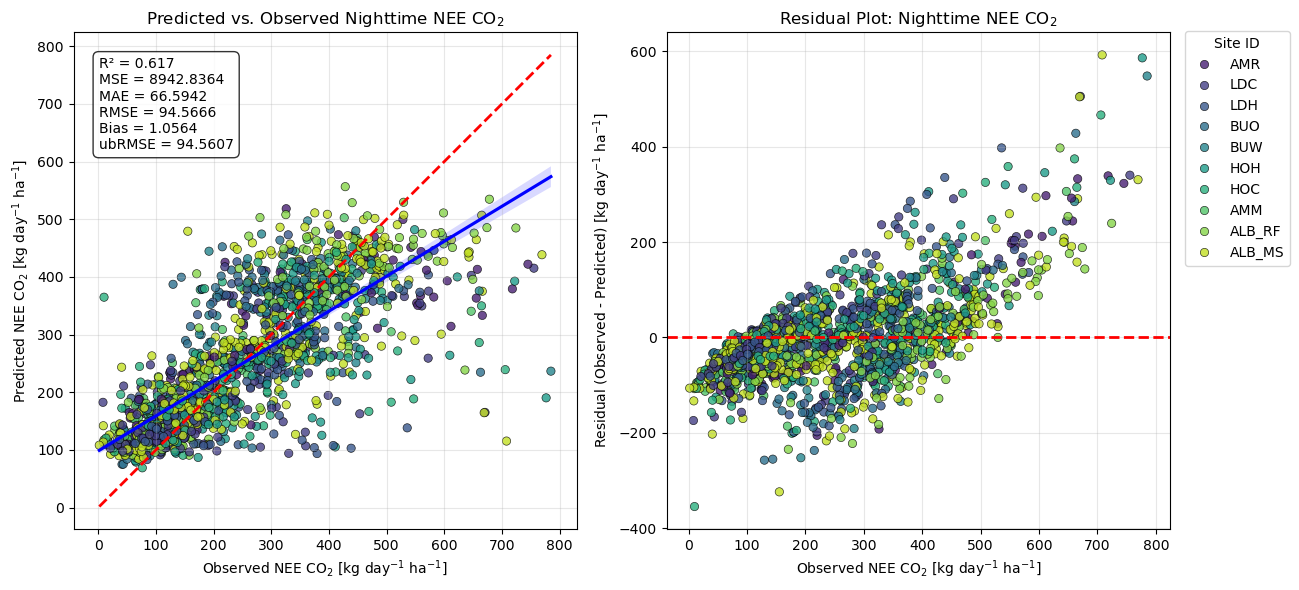

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=merged_df, x='Actual_NEE', y='Predicted_NEE',
                hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=axes[0], legend=False) 

min_val = min(merged_df['Actual_NEE'].min(), merged_df['Predicted_NEE'].min())
max_val = max(merged_df['Actual_NEE'].max(), merged_df['Predicted_NEE'].max())
x_vals = np.linspace(min_val, max_val, 100)
axes[0].plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2, label="1:1 Line")

sns.regplot(data=merged_df, x='Actual_NEE', y='Predicted_NEE',
            scatter=False, color='blue', ax=axes[0], line_kws={'label': "Regression Line"})

axes[0].set_title('Predicted vs. Observed Nighttime NEE CO$_2$')
axes[0].set_xlabel('Observed NEE CO$_2$ [kg day$^{-1}$ ha$^{-1}$]')
axes[0].set_ylabel('Predicted NEE CO$_2$ [kg day$^{-1}$ ha$^{-1}$]')
axes[0].grid(alpha=0.3)
axes[0].axis('equal') 

metrics_text = (
    f"R² = {r2:.3f}\n"
    f"MSE = {mse:.4f}\n"
    f"MAE = {mae:.4f}\n"
    f"RMSE = {rmse:.4f}\n"
    f"Bias = {bias:.4f}\n"
    f"ubRMSE = {ubrmse:.4f}"
)

axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='left',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

sns.scatterplot(data=merged_df, x='Actual_NEE', y='Residual',
                hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=axes[1], legend=False) 

axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Residual Plot: Nighttime NEE CO$_2$')
axes[1].set_xlabel('Observed NEE CO$_2$ [kg day$^{-1}$ ha$^{-1}$]')
axes[1].set_ylabel('Residual (Observed - Predicted) [kg day$^{-1}$ ha$^{-1}$]')
axes[1].grid(alpha=0.3)

sites = merged_df['Site_ID'].unique()                    # Determine the unique sites for the legend
fig_legend = plt.figure(figsize=(3, len(sites)*0.5 + 1)) # Adjust figure size based on number of sites
legend_ax = fig_legend.add_subplot(111)
# Plot a temporary scatter to get legend handles and labels
legend_plot = sns.scatterplot(data=merged_df, x='Actual_NEE', y='Residual',
                              hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=legend_ax)
handles, labels = legend_ax.get_legend_handles_labels()
plt.close(fig_legend) 

fig.legend(handles=handles, labels=labels, title='Site ID',
           bbox_to_anchor=(0.85, 0.94), loc='upper left', borderaxespad=0)
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RQ3_Model_Reg_plot.png"  
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

#### Plot the non-linear regression line of predicted Nighttime NEE CO$_2$ values against the actual NEE CO$_2$ and Planet_SWC values

In [ ]:
# Create a figure for the NEE vs. Planet_SMC plot
fig_nee_smc = plt.figure(figsize=(7, 6))
ax_nee_smc = fig_nee_smc.add_subplot(111)

sorted_df = merged_df.sort_values('Planet_SMC').copy() 

sns.scatterplot(data=sorted_df, x='Planet_SMC', y='Actual_NEE',
                 hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=ax_nee_smc, legend=True)

# Plot the model-predicted NEE as a line
sns.lineplot(data=sorted_df, x='Planet_SMC', y='Predicted_NEE',
             color='red', label='Model Prediction', ax=ax_nee_smc) 

ax_nee_smc.set_xlabel('Planet_SMC [m$^{3}$ m$^{-3}$]')
ax_nee_smc.set_ylabel('NEE CO$_2$ [kg day$^{-1}$ ha$^{-1}$]')
#ax_nee_smc.set_title('Nighttime NEE vs. Planet_SMC with Model Prediction (Observed Conditions)') 

ax_nee_smc.legend(handles=handles, labels=labels, title='', 
                  bbox_to_anchor=(1, 1.009), loc='upper left')

ax_nee_smc.grid(alpha=0.3)
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RQ3_Model_relationship.png"
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

#### Plot the non-linear regression line of predicted nighttime NEE values by holding the independant variables constant (mean values)

In [ ]:
# Get mean values of the other independent variables from the cleaned data
mean_gpp = cleaned_df['GPP_NT_kg_day_ha_DAv_NT'].mean()
mean_t_air = cleaned_df['ATMP_f'].mean()
mean_t_soil = cleaned_df['STMP_1_015'].mean()

# Get the range of observed SMC values
min_smc = cleaned_df['Planet_SMC'].min()
max_smc = cleaned_df['Planet_SMC'].max()

# Create a smooth range of SMC values
smooth_smc_range = np.linspace(min_smc, max_smc, 1000)

# Create synthetic independent variables for the smooth plot
# GPP, T_air, and T_soil are held constant at their mean values
synthetic_independent_data = (
    np.full_like(smooth_smc_range, mean_gpp),   # Constant mean GPP
    np.full_like(smooth_smc_range, mean_t_air), # Constant mean Air Temp
    smooth_smc_range,                           # Smooth range of SMC
    np.full_like(smooth_smc_range, mean_t_soil))  # Constant mean Soil Temp

# Calculate the predicted NEE using the model with the fixed parameters and the synthetic data
smooth_predicted_nee = full_nee_model_5param(synthetic_independent_data, *final_fitted_params_5param)

# Create a figure and axes for the smooth plot
fig_nee_smc_smooth = plt.figure(figsize=(7, 6))
ax_nee_smc_smooth = fig_nee_smc_smooth.add_subplot(111)
sns.scatterplot(data=merged_df, x='Planet_SMC', y='Actual_NEE',
                hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=ax_nee_smc_smooth, legend=True)
ax_nee_smc_smooth.plot(smooth_smc_range, smooth_predicted_nee,
                       color='red', linewidth=2, label='Model Prediction (Other Vars at Mean)')
ax_nee_smc_smooth.set_xlabel('Planet_SMC')
ax_nee_smc_smooth.set_ylabel('NEE CO$_2$ [kg day$^{-1}$ ha$^{-1}$]')
ax_nee_smc_smooth.set_title('Nighttime NEE vs. Planet_SMC - Smooth Model Response')
ax_nee_smc_smooth.legend(handles=handles, labels=labels, title='',
                         bbox_to_anchor=(1, 1.009), loc='upper left')

ax_nee_smc_smooth.grid(alpha=0.3)
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RQ3_Model_control.png"
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
#plt.show()

#### Combined plot of model prediction from actual data and Smooth model response with other vars held constant

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RQ3_Combined_plot.png


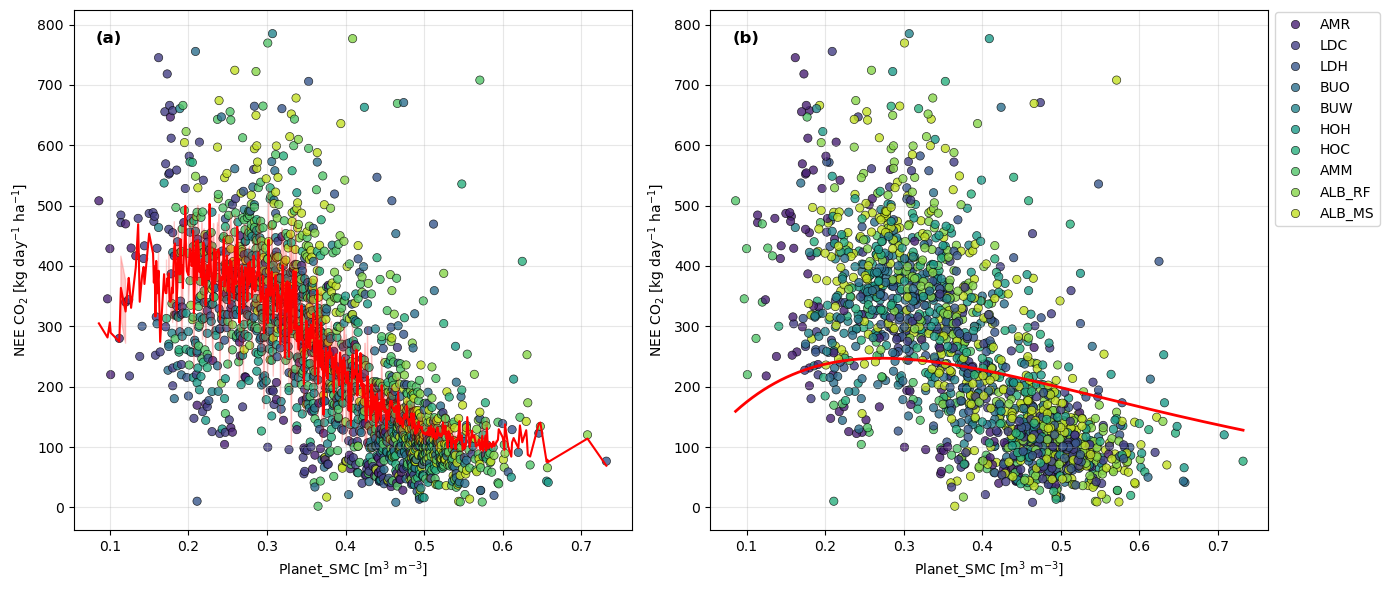

In [11]:
# Sort for first plot
sorted_df = merged_df.sort_values('Planet_SMC').copy()

# Prepare synthetic data for the second plot
mean_gpp = cleaned_df['GPP_NT_kg_day_ha_DAv_NT'].mean()
mean_t_air = cleaned_df['ATMP_f'].mean()
mean_t_soil = cleaned_df['STMP_1_015'].mean()

min_smc = cleaned_df['Planet_SMC'].min()
max_smc = cleaned_df['Planet_SMC'].max()
smooth_smc_range = np.linspace(min_smc, max_smc, 1000)

synthetic_independent_data = (
    np.full_like(smooth_smc_range, mean_gpp),
    np.full_like(smooth_smc_range, mean_t_air),
    smooth_smc_range,
    np.full_like(smooth_smc_range, mean_t_soil)
)

smooth_predicted_nee = full_nee_model_5param(synthetic_independent_data, *final_fitted_params_5param)

# Create combined figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Model prediction from actual data 
sns.scatterplot(data=sorted_df, x='Planet_SMC', y='Actual_NEE',
                hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=axes[0], legend=False)
sns.lineplot(data=sorted_df, x='Planet_SMC', y='Predicted_NEE',
             color='red', label='', ax=axes[0]) 
axes[0].set_xlabel('Planet_SMC [m$^{3}$ m$^{-3}$]')
axes[0].set_ylabel('NEE CO$_2$ [kg day$^{-1}$ ha$^{-1}$]')
axes[0].grid(alpha=0.3)
axes[0].text(0.04, 0.96, '(a)', transform=axes[0].transAxes,
             fontsize=12, fontweight='bold', va='top', ha='left')

# Subplot 2: Smooth model response with other vars held constant 
sns.scatterplot(data=merged_df, x='Planet_SMC', y='Actual_NEE',
                hue='Site_ID', palette='viridis', edgecolor='k', alpha=0.8, ax=axes[1], legend=True)
axes[1].plot(smooth_smc_range, smooth_predicted_nee,
             color='red', linewidth=2, label='')
axes[1].set_xlabel('Planet_SMC [m$^{3}$ m$^{-3}$]')
axes[1].set_ylabel('NEE CO$_2$ [kg day$^{-1}$ ha$^{-1}$]')
axes[1].legend(handles=handles, labels=labels, title='',
               bbox_to_anchor=(1, 1.009), loc='upper left')
axes[1].grid(alpha=0.3)
axes[1].text(0.04, 0.96, '(b)', transform=axes[1].transAxes,
             fontsize=12, fontweight='bold', va='top', ha='left')

plt.tight_layout()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RQ3_Combined_plot.png"
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

#### Model Predicted NEE vs. Planet_SMC for GPP~0 Scenario 
- This plot explores how the model predicts nighttime respiration-driven NEE CO₂ and how it varies with soil moisture under near-zero GPP (photosynthesis) conditions.
  
- Uses synthetic input to hold GPP at 0, air temp at 15°C, and soil temp at the mean value from GPP~0 data.
- Generates a smooth model curve showing how predicted NEE varies with SMC under this controlled condition.

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RQ3_model_GPP_0_plot.png


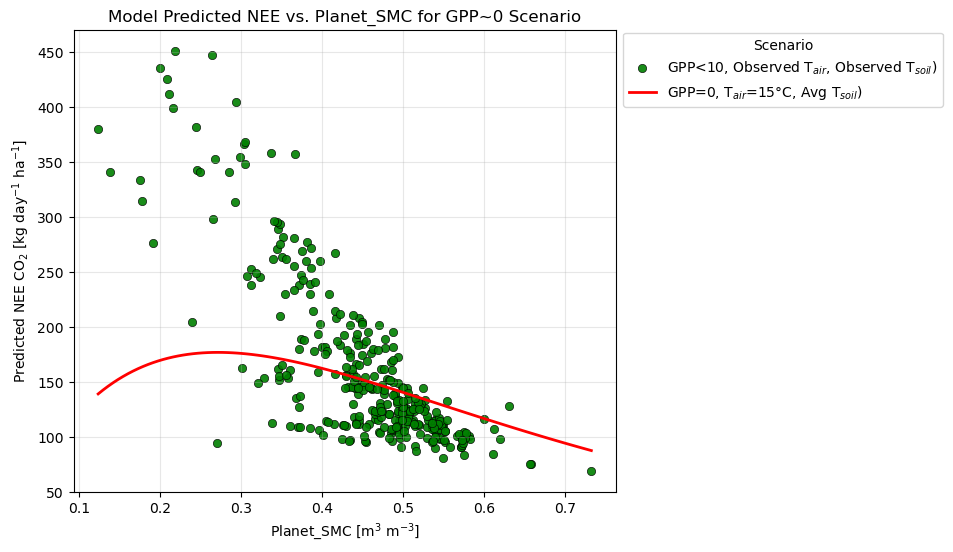

In [13]:
gpp_threshold = 10    # Define a small threshold for GPP to consider it "near 0"
fixed_tair_value = 15 # Define the fixed Tair value (e.g., 15C as in the example image)
fixed_gpp_value = 0   # Use a constant GPP value that represents 'near zero' for the synthetic data (e.g., 0)

gpp_zero_df = cleaned_df[cleaned_df['GPP_NT_kg_day_ha_DAv_NT'] < gpp_threshold].copy() # Filter the cleaned data for GPP near 0
representative_t_soil_gpp_zero = gpp_zero_df['STMP_1_015'].mean()                      # Get representative Soil Temp for this subset (using mean Soil Temp for GPP~0 data)

# 1. Prepare data for Scatter Dots (Model prediction using Observed Tair for GPP~0 data)
independent_data_gpp_zero = (
    gpp_zero_df['GPP_NT_kg_day_ha_DAv_NT'].values, # Observed GPP (~0)
    gpp_zero_df['ATMP_f'].values,                  # Observed Air Temp
    gpp_zero_df['Planet_SMC'].values,              # Observed SMC
    gpp_zero_df['STMP_1_015'].values)              # Observed Soil Temp
        
# Calculate predicted NEE for these specific observed conditions
predicted_nee_observed_tair_gpp_zero = full_nee_model_5param(independent_data_gpp_zero, *final_fitted_params_5param)

# Create a DataFrame for plotting the scatter dots
scatter_plot_df = pd.DataFrame({'Planet_SMC': gpp_zero_df['Planet_SMC'].values,
                                'Predicted_NEE': predicted_nee_observed_tair_gpp_zero})

# 2. Prepare data for Smooth Line (Model prediction using Fixed Tair for GPP=0 scenario)
# Get the range of SMC values to plot the smooth line over
min_smc_subset = gpp_zero_df['Planet_SMC'].min()
max_smc_subset = gpp_zero_df['Planet_SMC'].max()
smooth_smc_range_subset = np.linspace(min_smc_subset, max_smc_subset, 100)

# Create synthetic independent variables for the smooth line
synthetic_independent_data_fixed_tair = (
    np.full_like(smooth_smc_range_subset, fixed_gpp_value),                # GPP fixed at ~0
    np.full_like(smooth_smc_range_subset, fixed_tair_value),               # Air Temp fixed at 15C (or other value)
    smooth_smc_range_subset,                                               # Smooth range of SMC
    np.full_like(smooth_smc_range_subset, representative_t_soil_gpp_zero)) # Soil Temp fixed at mean of GPP~0 subset

# Calculate predicted NEE for this synthetic data
predicted_nee_fixed_tair_gpp_zero = full_nee_model_5param(synthetic_independent_data_fixed_tair, *final_fitted_params_5param)

# 3. Create the Plot
fig_gpp_zero_scenario = plt.figure(figsize=(7, 6))
ax_gpp_zero_scenario = fig_gpp_zero_scenario.add_subplot(111)
sns.scatterplot(data=scatter_plot_df, x='Planet_SMC', y='Predicted_NEE',
                color='green', edgecolor='k', alpha=0.9,ax=ax_gpp_zero_scenario, 
                label=f'GPP<{gpp_threshold}, Observed T$_{{air}}$, Observed T$_{{soil}}$)') 
ax_gpp_zero_scenario.plot(smooth_smc_range_subset, predicted_nee_fixed_tair_gpp_zero,
                          color='red', linewidth=2, 
                          label=f'GPP={fixed_gpp_value}, T$_{{air}}$={fixed_tair_value}°C, Avg T$_{{soil}}$)') 
ax_gpp_zero_scenario.set_xlabel('Planet_SMC [m$^{3}$ m$^{-3}$]')
ax_gpp_zero_scenario.set_ylabel('Predicted NEE CO$_2$ [kg day$^{-1}$ ha$^{-1}$]')
ax_gpp_zero_scenario.set_title('Model Predicted NEE vs. Planet_SMC for GPP~0 Scenario')
handles, labels = ax_gpp_zero_scenario.get_legend_handles_labels()
ax_gpp_zero_scenario.legend(handles=handles, labels=labels, title='Scenario',
                            bbox_to_anchor=(1, 1.009), loc='upper left')
ax_gpp_zero_scenario.grid(alpha=0.3)

#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/RQ3_model_GPP_0_plot.png"
#plt.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()